<a href="https://colab.research.google.com/github/steffen-mdv/meep_lens/blob/main/meep_lens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Colab Notebook to run FDTD simulations with meep

Author: Steffen Michaelis de Vasconcellos

## Installation
First, we install CondaLab via pip to have the convenient Conda environment. It takes about 30 seconds. The session will send a message that it has crashed - this is normal. The environment is deleted each time you reconnect to Google Colab, so keep the runtime open.


In [183]:
try:
  import condacolab
  condacolab.check()
except ImportError:
  !pip install -q condacolab
  import condacolab
  condacolab.install()


✨🍰✨ Everything looks OK!


Then we install meep via anaconda. We don't want to see the output. Takes about 1 minute.

In [184]:
%%capture
try:
  import meep as matplotlib
except ImportError:
  !conda install -c conda-forge pymeep

# Meep simulation

Now we can run a meep simulation. The meep documentation is found here: https://meep.readthedocs.io/en/latest/Python_User_Interface/

## Import packages



In [185]:
import math
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

## Define constants
Define some physical constants of the simulation (e.g. refractive index, wavelength) and some parameters of the FDTD simulation (e.g. resolution, size of the simulation grid)

Most important: Defines the parameters of the elliptical lens and the polarization of the dipole source. Here you can change things!

In [186]:
#refractive indieces
index_lens = 1.55
index_substrate = 1.476
index_air = 1
index_hBN = 2.2


#define lens parameters
lens_a = 7.5
lens_b = lens_a*index_lens/(index_lens**2-index_air**2)**(1/2)
lens_h = lens_a*((index_lens+index_air)/(index_lens-index_air))**(1/2)

lens_offset = 0
lens_offset_x = 0

print('Lens parameters:')
print('Lens short axis (a):', lens_a)
print('Lens long axis (b):', lens_b)
print('Lens height (h):', lens_h)
print('Lens offset (y):', lens_offset)
print('Lens offset (x):', lens_offset_x)

#source polarization "s" or "p" or "z" or "45°"
source_direction = "p"

#wavelength in um
wavelength = 0.625


## Calculate and define some further constants for the simulation - don't edit unless you know what you are doing

#frequency
fcen = 1/wavelength

#resolution
resolution = 16

hBN_height = 2/resolution #center of the dipole emitter, 1 grid point above the substrate surface

#resolution is set via parameters alternative here:
#resolution_per_wavelength = 8
#resolution = int(np.floor(resolution_per_wavelength*fcen*index_lens))  # pixels/um
print("Resolution", resolution)

dpml = 1

#defince simulation cell size. size_x and y are parameters multiplies with lens size
size_y = 15
size_x = 8
sx = np.floor(size_x*(lens_a))+1  #size of simulation area
sy = np.floor(size_y*(lens_a))+1

substrate_height = sy/2 + dpml #- extra_space
substrate_x = sx + 2*dpml #- extra_space


Lens parameters:
Lens short axis (a): 7.5
Lens long axis (b): 9.816157693907416
Lens height (h): 16.14916265771865
Lens offset (y): 0
Lens offset (x): 0
Resolution 16


## Define the geometry in meep
Here an ellipsoid is chosen for the lens. You could modify that line, but better is to modify the parameters above.

In [201]:
#define geometry
geometry = []

#lens
geometry.append(
    mp.Ellipsoid(
      center=mp.Vector3(lens_offset_x,lens_b-lens_h-lens_offset,0),
      size=mp.Vector3(2*lens_a,2*lens_b,2*lens_b),
      e1=mp.Vector3(1,0,0), e2=mp.Vector3(0,1,0), e3=mp.Vector3(0,0,1),
      material=mp.Medium(index=index_lens)))

#substrate
geometry.append(
    mp.Block(
        size=mp.Vector3(substrate_x, substrate_height, 0),
        center=mp.Vector3(0,substrate_height/2,0),
        material=mp.Medium(index=index_substrate)))

## Define the dipole source in meep
don't edit here

In [188]:
if source_direction == "p":
    print("Source direction Ex")
    src_cmpt = mp.Ex
elif source_direction == "s":
    print("Source direction Ez")
    src_cmpt = mp.Ez
elif source_direction == "z":
    print("Source direction perpendicular to surface (Ey)")
    src_cmpt = mp.Ey

sources = [mp.Source(src=mp.ContinuousSource(fcen),
                     center=mp.Vector3(0,-hBN_height/2,0),
                     component=src_cmpt)]

Source direction Ex


## Setup the simulation
don't edit here. Running this cell resets also the simulation.

In [189]:
#caluclate cell
cell = mp.Vector3(sx+2*dpml,sy+2*dpml)  #size of computation cell

#make PML
pml_layers = [mp.PML(dpml)]

#add symmetries
#in a 2D simulation (optical axis in Y direction), we have only symmetires in X direction. This can be either inverted (phase=-1) or normal.
if src_cmpt == mp.Ex:
    symmetries = [mp.Mirror(mp.X,phase=-1)]
elif src_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X,phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X,phase=+1)]

if lens_offset_x != 0:
  symmetries = []

#make simulation
sim = mp.Simulation(cell_size=cell,
                    resolution=resolution,
                    sources=sources,
                    geometry=geometry,
                    symmetries=symmetries,
                    boundary_layers=pml_layers,
                    force_complex_fields=True)



## Run the simulation
Running for a certain amount of timesteps (e.g. 100). You can run this cell multiple times to continoue the simulation. `until` means that that number of step is added to the simulation. The number of timesteps required that the light propagates through the whole cell depends on the size of the cell and the resolution

In [ ]:
run_until = 10
sim.run(until=run_until)

## Analyze

After running the simulation, we can analyze the output. Here we plot the total power of the electric field overlayed with epsilon.

Edit vmax if the color scale is not appropriate.

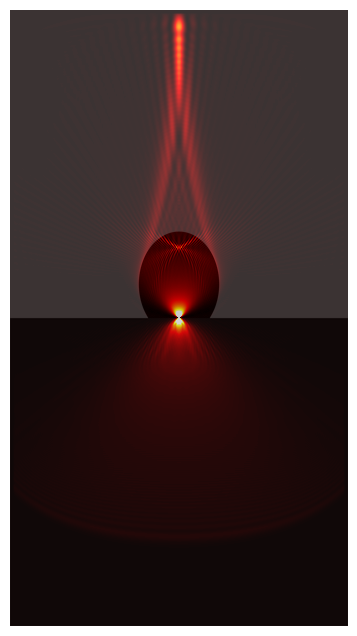

In [203]:
eps_data = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Dielectric)
#ez_data = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Ez)
tot_pwr = sim.get_tot_pwr().transpose()
plt.figure(figsize=(10,8))
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(tot_pwr, interpolation='spline36', cmap='hot', vmin=0,vmax=.5,alpha=0.8)
plt.axis('off')
plt.show()